In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33587")
client

<Client: 'tcp://127.0.0.1:33587' processes=8 threads=32, memory=125.87 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/spectre/tuchida/chaocean/Snap/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

xchunk = 100
ychunk = 100

nmembs = np.arange(100,148)

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 53  # 
yystart = 0
ntimes[yystart,dd:]

array([1533600, 1535760, 1537920, 1540080, 1542240, 1544400, 1546560,
       1548720, 1550880, 1553040, 1555200, 1557360, 1559520, 1561680,
       1563840, 1566000, 1568160, 1570320, 1572480, 1574640])

In [6]:
dsg = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                              % (100)), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=ntimes[0,0], 
                     ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                           'XC':xchunk,'XG':xchunk})
grid = Grid(dsg, periodic=['X'])
Vol = (dsg.rA * dsg.drF * dsg.hFacC).where(dsg.maskC!=0.)
dsg

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46)
Coordinates: (12/33)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
Data variables:
    THETA    (Z, YC, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    SALT     (Z, YC, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    UVEL     (Z, YC, XG) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    VVEL     (Z, YG, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    WVEL     (Zl, YC, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

## Ensemble mean

In [12]:
for itime in ntimes[yystart]:
    dsm = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=itime, 
                         ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                               'XC':xchunk,'XG':xchunk})
    grid = Grid(dsm, periodic=['X'])
    dsb = xr.open_zarr(op.join(savedir,'%04d/ensm/%010d/BUOY.zarr' 
                               % (years[0],itime))
                      )
    
    if itime == ntimes[yystart,0]:
        WB = (grid.interp(dsm.WVEL,'Z',boundary='extend')
              * dsb.BUOY.where(dsm.maskC!=0.)
             )
    else:
        WB = xr.concat([WB, (grid.interp(dsm.WVEL,'Z',boundary='extend')
                             * dsb.BUOY.where(dsm.maskC!=0.)
                            )
                       ], 'time')
    dsm.close()
    dsb.close()
WB

<xarray.DataArray (time: 73, Z: 46, YC: 900, XC: 1000)>
dask.array<concatenate, shape=(73, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    Depth    (YC, XC) float32 3.441e+03 3.215e+03 ... 2.917e+03 2.824e+03
    PHrefC   (Z) float32 29.89 92.74 160.5 ... 5.273e+04 5.518e+04 5.764e+04
    drF      (Z) float32 6.094 6.721 7.099 7.971 ... 248.9 249.6 249.9 250.5
    ...       ...
    iter     (time) int64 1419120 1421280 1423440 ... 1570320 1572480 1574640
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInC  (YC, XC) bool False False False False ... False False False False
    rA       (YC, XC) float32 8.334e+07 8.334e+07 ... 5.084e+07 5.084e+07
    rhoRef   (Z) float32 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
  * time     (time) timedelta64[ns] 3285 days 3290 days ... 3640 days 3645 days

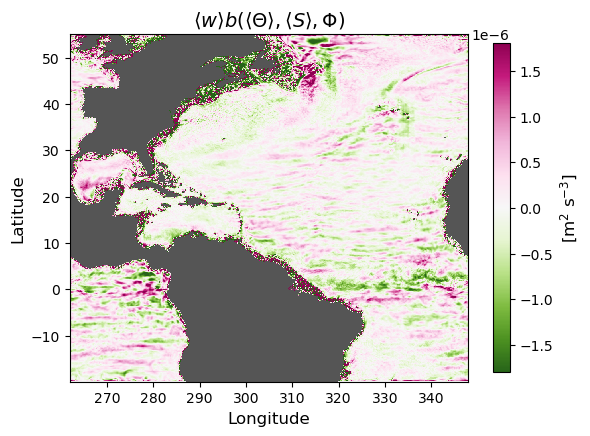

In [9]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(dsg.XC, dsg.YC, WB.isel(time=0,Z=0),
                   vmin=-1.8e-6, vmax=1.8e-6, cmap='PiYG_r', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w\rangle b(\langle\Theta\rangle, \langle S\rangle, \Phi)$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/wbbb_%010d.pdf' % ntimes[0,0]))

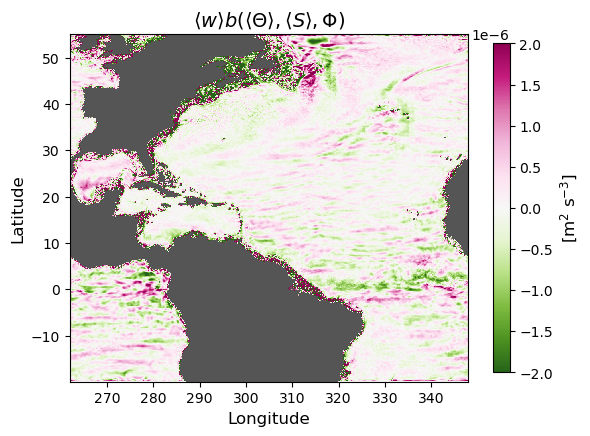

In [15]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(dsg.XC, dsg.YC, 
                   WB.isel(time=0).sel(Z=8e2,method='nearest'),
                   vmin=-2e-6, vmax=2e-6, cmap='PiYG_r', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).sel(Z=800,method='nearest'),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w\rangle b(\langle\Theta\rangle, \langle S\rangle, \Phi)$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/wbbb_Z800_%010d.pdf' % ntimes[0,0]))

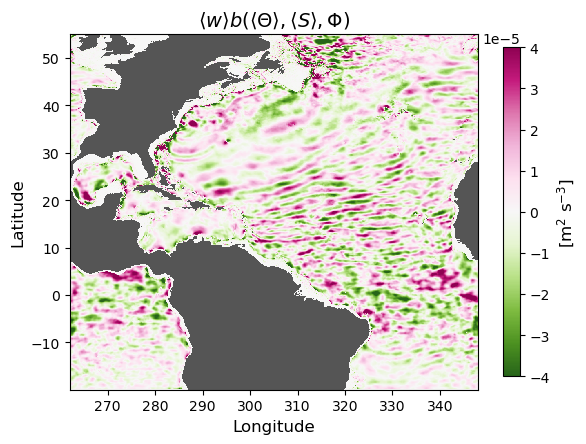

In [10]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(dsg.XC, dsg.YC, 
                   ((WB*dsg.drF).isel(time=0).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
                    * 1e-3),
                   vmin=-4e-5, vmax=4e-5, cmap='PiYG_r', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
              vmin=-2, vmax=1, cmap='binary', rasterized=True)

ax.set_title(r"$\langle w\rangle b(\langle\Theta\rangle, \langle S\rangle, \Phi)$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/wbbb_Z1000ave_%010d.pdf' % ntimes[0,0]))

In [15]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337
((WB*Vol).sel(
              # Z=slice(None,-1e3),YC=slice(ymin,ymax),
              # XC=slice(xmin,xmax)
             ).sum(['Z','YC','XC'],skipna=True)
 / Vol.sel(
           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
           # XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
).chunk({'time':-1}).to_dataset(name='WB').to_zarr(op.join(savedir,
                                   #                  '%4d/WB_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                                   # % (years[yystart],ymin,ymax,xmin,xmax)
                                                        '%4d/WB_VolAve.zarr' 
                                   % (years[yystart])
                                                          ), mode='w')

## Eddy

In [9]:
for itime in ntimes[yystart,dd+1:]:
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=itime, 
                                ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                      'XC':xchunk,'XG':xchunk})
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=itime, 
                                               ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                                     'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')

    ds.coords['nmemb'] = ('nmemb',nmembs)
    grid = Grid(ds, periodic=['X'])
    
    dsb = xr.open_zarr(op.join(savedir,'%04d/%010d/BUOY.zarr' 
                               % (years[0],itime))
                      )
    
    dsm = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=itime, 
                         ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                               'XC':xchunk,'XG':xchunk})
    dsbm = xr.open_zarr(op.join(savedir,'%04d/ensm/%010d/BUOY.zarr' 
                                % (years[0],itime))
                       )
    
    wp = grid.interp(ds.WVEL - dsm.WVEL,'Z',boundary='extend')
    bp = (dsb.BUOY - dsbm.BUOY).where(ds.maskC!=0.)
    
    wb = (wp*bp).mean('nmemb')
    
    if itime == ntimes[yystart,dd]:
        wb.isel(Z=1).plot(vmax=1e-7)
        plt.show()
    
    dsave = wb.reset_coords(drop=True).chunk({'Z':4,'YC':ychunk,'XC':xchunk}
                ).to_dataset(name='wb')
    dsave.to_zarr(op.join(savedir,'%4d/%010d/Eddy/wb.zarr' 
                          % (years[yystart],itime))
        # op.join(savedir,'wb/%010d.zarr' % itime)
        , mode='w')
    dsave.close()
    ds.close()
    dsb.close()
    dsm.close()
    dsbm.close()
    del wb
    
    print(itime)

1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


In [16]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337

for itime in ntimes[yystart]:
    if itime == ntimes[yystart,0]:
        wb = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/wb.zarr' 
                                  % (years[yystart],itime))
                         ).wb.reset_coords(drop=True)
    else:
        wb = xr.concat([wb, xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/wb.zarr' 
                                  % (years[yystart],itime))
                                        ).wb.reset_coords(drop=True)
                       ], 'time')
    print(itime)
wb.coords['time'] = WB.time
  

In [17]:
((wb*Vol).sel(
           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
           # XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
 / Vol.sel(
           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
           # XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
).reset_coords(drop=True).chunk({'time':-1}
                               ).to_dataset(name='wb').to_zarr(op.join(savedir,
                                          # '%4d/wpbp_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                                          # % (years[yystart],ymin,ymax,xmin,xmax)
                                      '%4d/wpbp_VolAve.zarr' 
                                      % (years[yystart])
                                                                      ), mode='w')